### Title: Forecasting COVID-19 cases by assessing control -intervention effects in Republic of Korea: a statistical modeling approach

In [1]:
rm(list=ls())

In [3]:
# Load libraires
libraries = c("deSolve","dplyr","Bhat","reshape2","gridExtra","ggpubr","openxlsx","matrixStats","tidyquant","ggplot2",
              "magrittr","scales","tidyr","grid")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE) }


In [4]:
main_folder = "../Result/"

#time interval for data-fitting
startday.est = as.Date("2020-07-16")
finalday = as.Date("2021-03-04")


#serial interval
serial_esti = c(4.8,2.3)
xlabel_epi = "Confirmed date (month/day)"


In [5]:
# figure options
ymax_vector = 1300
ydiff_vector = 300
xdiff = "14 days"
#cols <- c("Local" = "gray60","Imported"="blue")
x_fig = seq(as.Date(startday.est),finalday,by="7 day")

#data load

dfone= read.xlsx("../../Data/dfone_korea.xlsx",sheet="Sheet 1",detectDates=TRUE,colNames=T,startRow=1)%>%
  filter(day<=as.Date("2021-03-04"))
dfone%>%head

i.local,day,time,cum_case
14,2020-07-16,1,11651
21,2020-07-17,2,11672
11,2020-07-18,3,11683
21,2020-07-19,4,11704
4,2020-07-20,5,11708
20,2020-07-21,6,11728


## Parameter and initial condition

In [6]:
area_name = "Korea"
pop0=51779203
total.case = dfone$cum_case[1]-dfone$i.local[1]
i0.est = dfone%>%filter(day==startday.est)%>%dplyr::select(i.local)%>%as.numeric()
p.ode = data.frame(alpha1=1/5,alpha2=1/3,
                   gamma=1/14,N=pop0,w=0,alpha3=1/5)
(init0 = c(p.ode$N-i0.est,0,i0.est,0,0,i0.est,0))
(pp = p.ode)
dtts=1

[1] 51779189        0       14        0        0       14        0

alpha1,alpha2,gamma,N,w,alpha3
0.2,0.3333333,0.07142857,51779203,0,0.2


## Simulation for ODE model

In [7]:

date1=startday.est
daten =finalday
tmax = as.numeric(finalday-startday.est)


endday.est.1st = as.Date("2020-08-06")
control_date = c(endday.est.1st+1,as.Date("2020-08-16"),as.Date("2020-08-23"),
                  as.Date("2020-09-14"),as.Date("2020-09-28"),as.Date("2020-10-12"),
                  as.Date("2020-11-05"),
                  as.Date("2020-12-08"),as.Date("2020-12-23"),as.Date("2021-02-01"),as.Date("2021-02-15"),finalday+1)


ft_sc_df = function(t1,tn,control_date){
  sc_df = data.frame(date=seq(t1,tn ,by="day"))%>%
    mutate(time=1:n())
  sc_df%<>%mutate(control_t=1)
  for(kk in 1:length(control_date)){
    sc_df$control_t[which(sc_df$date>=control_date[kk])] =  sc_df$control_t[which(sc_df$date>=control_date[kk])]+1
  }
  return(sc_df)
}

sc_df = ft_sc_df(date1,daten,control_date)
n_types = sc_df%>%group_by(control_t)%>%summarize(ngp=n())%>%.$ngp
ngroup = length(n_types)
sc_time_interval = data.frame(interval = 1:ngroup,
                               start.d=c(date1,control_date[1:(ngroup-1)]),
                               end.d=(control_date-1))


v.w = rep(0,ngroup)
v.a2=rep(p.ode$alpha2,ngroup)
v.gam =rep(p.ode$gamma,ngroup)
ft_time_pp =  function(control_date,endday.est,v.w,v.a2,v.gam){
  
  group = length(control_date)
  
  p.set = data.frame(matrix(rep(as.numeric(p.ode),each=group),nrow=group))
  colnames(p.set) =colnames(p.ode)
  p.sc = p.set
  p.sc$w = v.w
  p.sc$alpha2 = v.a2
  p.sc$gamma = v.gam
  p.sc
  
  return(p.sc)
  
}
p.sc = ft_time_pp(control_date,endday.est,v.w,v.a2,v.gam)

(control_date)
source("function_ode.R")

[1] "2020-08-07" "2020-08-16" "2020-08-23" "2020-09-14" "2020-09-28"
 [6] "2020-10-12" "2020-11-05" "2020-12-08" "2020-12-23" "2021-02-01"
[11] "2021-02-15" "2021-03-05"

[1] 51703961.763     1853.039     1124.738     5444.906    66818.555
[6]    73388.198    72263.461

[1] "2021-03-04"

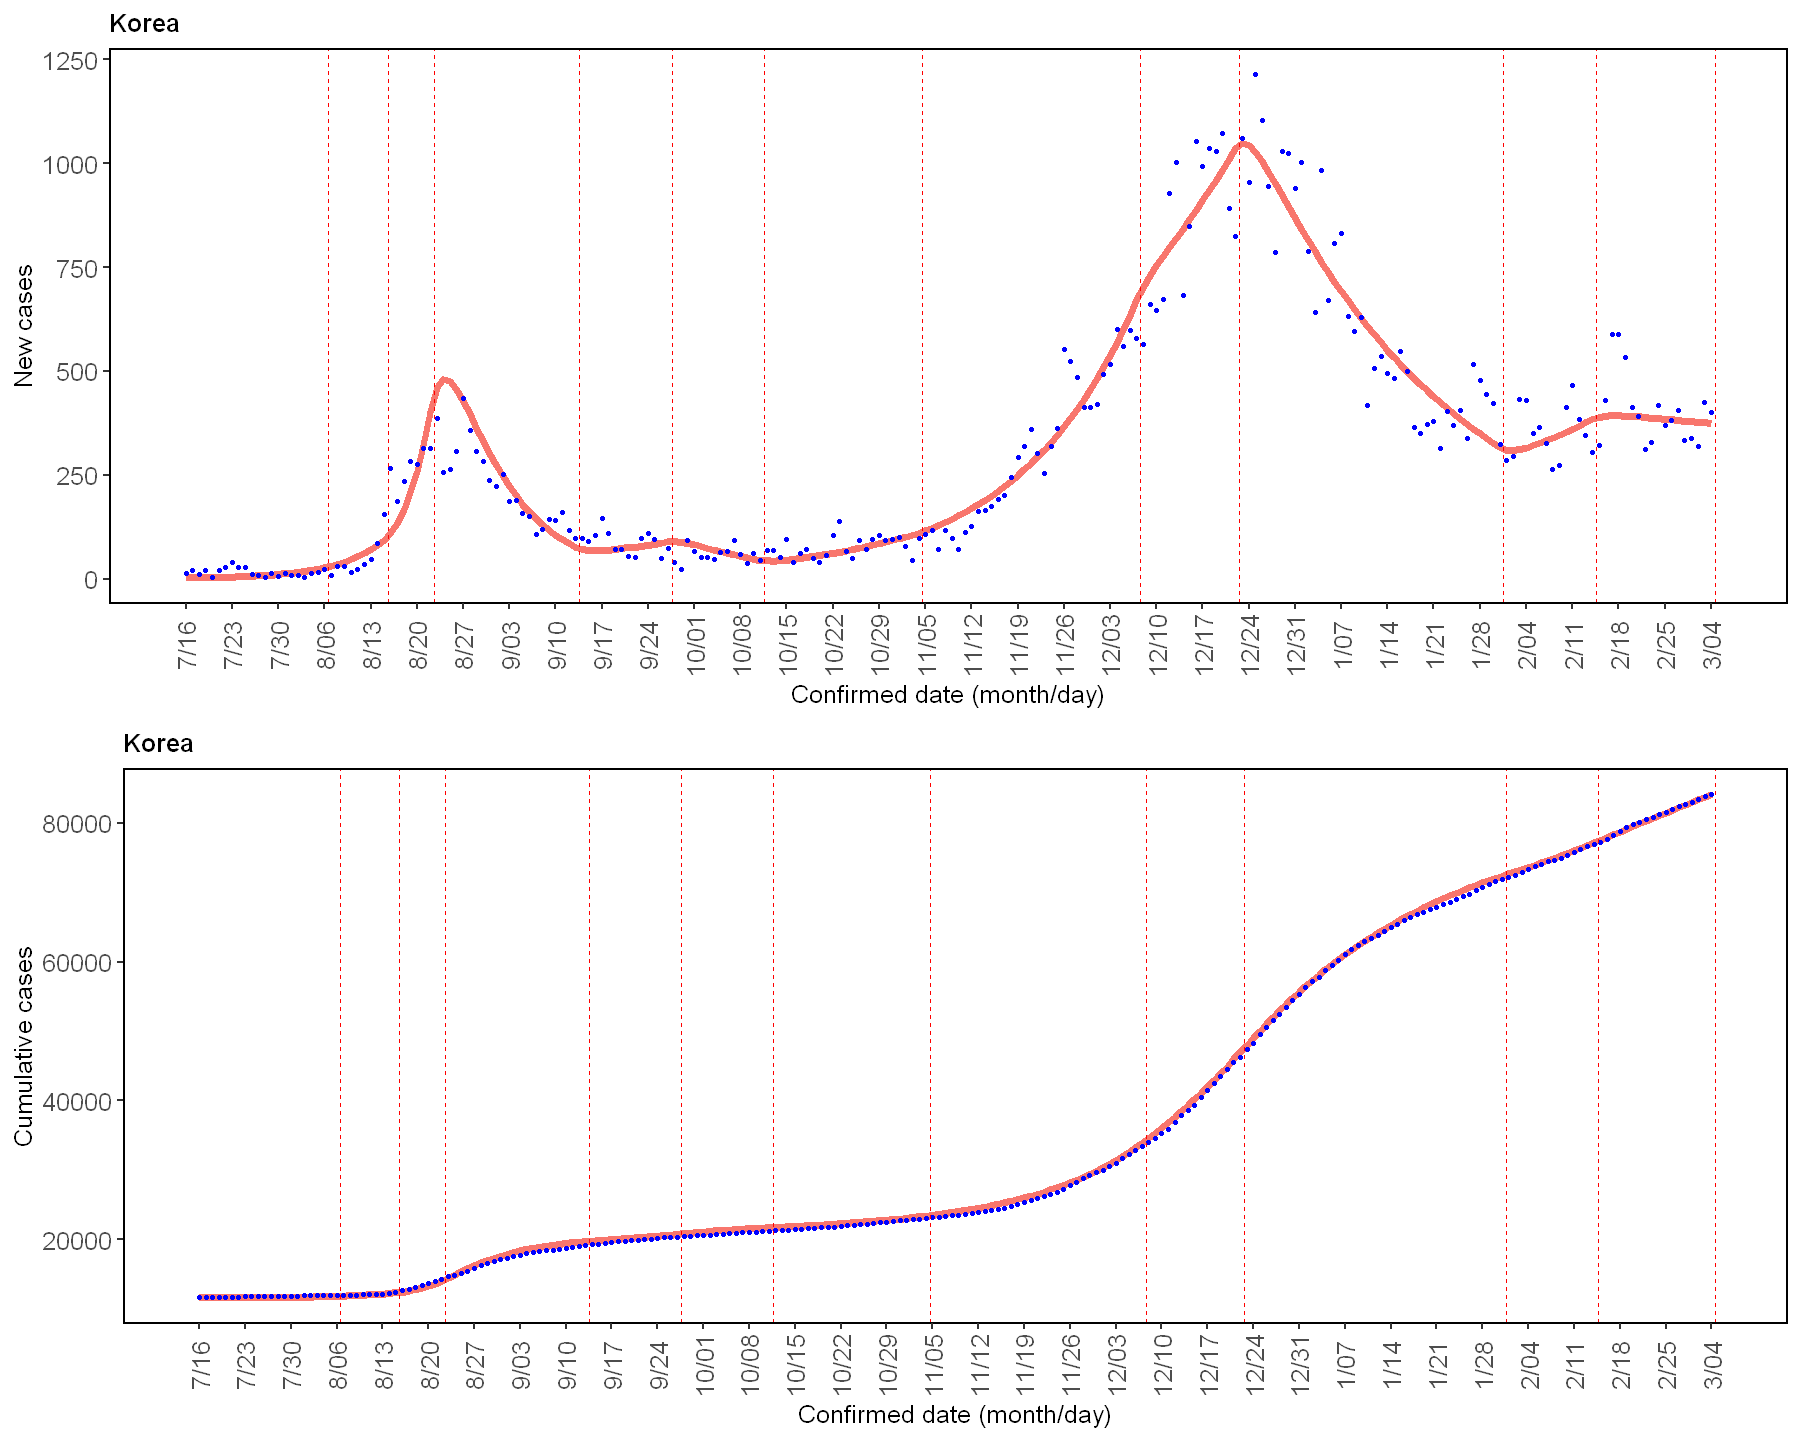

In [8]:

filenames_para = paste0(main_folder,"para_table_dfp_",area_name,".xlsx")
filenames_odefit = paste0(main_folder,"ode_fit_",area_name,".xlsx")


# up to now ---------------------------------------------------------------
comp_df = read.xlsx(filenames_odefit,sheet="Sheet 1",detectDates=TRUE,colNames=T,startRow=1)
para_tb = read.xlsx(filenames_para,sheet="Sheet 1",detectDates=TRUE,colNames=T,startRow=1)
p.ode = para_tb%>%dplyr::select(alpha1,alpha2,gamma,N,w,alpha3)%>%slice(1,)



results_list = list(comp_df,para_tb)


comp_df = results_list[[1]]
para_tb = results_list[[2]]

fit_ode_result=comp_df
(init_last = comp_df%>%dplyr::select(S,E,I,H,R,CI,HI)%>%tail(1)%>%as.numeric())
(fig_tmax = finalday)
legend_posi1=c(0.3,0.9);legend_posi2=c(0.5,0.9)

diff = "7 day"
x_startday = startday.est
cymax=ymax_vector
source("function_fig_ode_comp.R")
titles=area_name
fig = ft_fig_ode_comp(comp_df,x_fig,x_startday,fig_tmax,legend_posi1,xlabel_epi,cymax,titles)
  options(repr.plot.width=15,repr.plot.height=12)

plot_fit <-grid.arrange(fig[[1]],fig[[2]],nrow=2)


## Forecasting COVID-19 cases

In [11]:

# Forecasting -------------------------------------------------------------
sc_week = 4
sc_diff = 1

ngroup_esti = nrow(para_tb)
date1=para_tb$start.d[1]
daten =para_tb$end.d[1]
tmax = as.numeric(daten-date1)


diff = "7 day"
x_endday  = finalday
fig_tmax =para_tb$end.d[ngroup_esti]+7*sc_week

control_date_sc = c(para_tb$start.d[2:ngroup_esti],
                     para_tb$end.d[ngroup_esti]+1+seq(0,7*sc_week,by=sc_diff))

x_fig_sc = seq(x_fig[1],control_date_sc[length(control_date_sc)],by="7 day")


sc_df_future = ft_sc_df(date1,fig_tmax,control_date_sc)
n_types_sc = sc_df_future%>%group_by(control_t)%>%summarize(ngp=n())%>%.$ngp
ngroup_sc = length(n_types_sc)
sc_time_interval_sc = data.frame(interval = 1:ngroup_sc,start.d=c(date1,control_date_sc[1:(ngroup_sc-1)]),end.d=(control_date_sc-1))



v.w_sc = rep(0,ngroup_sc)
v.a2_sc=c(para_tb$alpha2,rep(1/3,ngroup_sc-ngroup_esti))
v.gam_sc = c(para_tb$gamma,rep(1/14,ngroup_sc-ngroup_esti))
p.sc_sc = ft_time_pp(control_date_sc,fig_tmax,v.w_sc,v.a2_sc,v.gam_sc)


betas = para_tb$esti_beta

filenames_forecast = paste0("../Result/Forecast_excel_load_Korea.xlsx")
combine_comp_df_sc = read.xlsx(filenames_forecast,sheet="Sheet 1",detectDates=TRUE,colNames=T,startRow=1)
comp_df_sc<-combine_comp_df_sc%>%group_by(SD)%>%group_split()



diff = "7 day"
x_endday  = x_fig_sc[length(x_fig_sc)]
x_startday.fig =as.Date("2020-12-31")
new_date.fig = seq(x_startday.fig,x_endday,by="7 days")
fontsize=12
df_future= read.xlsx("../../Data/dfone_korea.xlsx",sheet="Sheet 1",detectDates=TRUE,colNames=T,startRow=1)

final_combine_temp =   combine_comp_df_sc%>%dplyr::select(-c(i.local, cum_case,time))%>%left_join(df_future%>%rename(date=day),by=c("date"))%>%
  mutate(i.local=replace_na(i.local,0),
         cum_case=replace_na(cum_case,0))%>%filter(date>=x_startday.fig)

new_cumcase = final_combine_temp$cum_case[1]-final_combine_temp$i.local[1]

final_combine = final_combine_temp%>%group_by(SD)%>%
  mutate(cum_q1=cumsum(q1)+new_cumcase,
         cum_q2=cumsum(q2)+new_cumcase,
         cum_q3=cumsum(q3)+new_cumcase,
         cum_low=cumsum(low)+new_cumcase,
         cum_upp=cumsum(upp)+new_cumcase)%>%ungroup()

final_combine_sd = final_combine%>%group_by(SD)%>%group_split()
comp_dfa=final_combine_sd

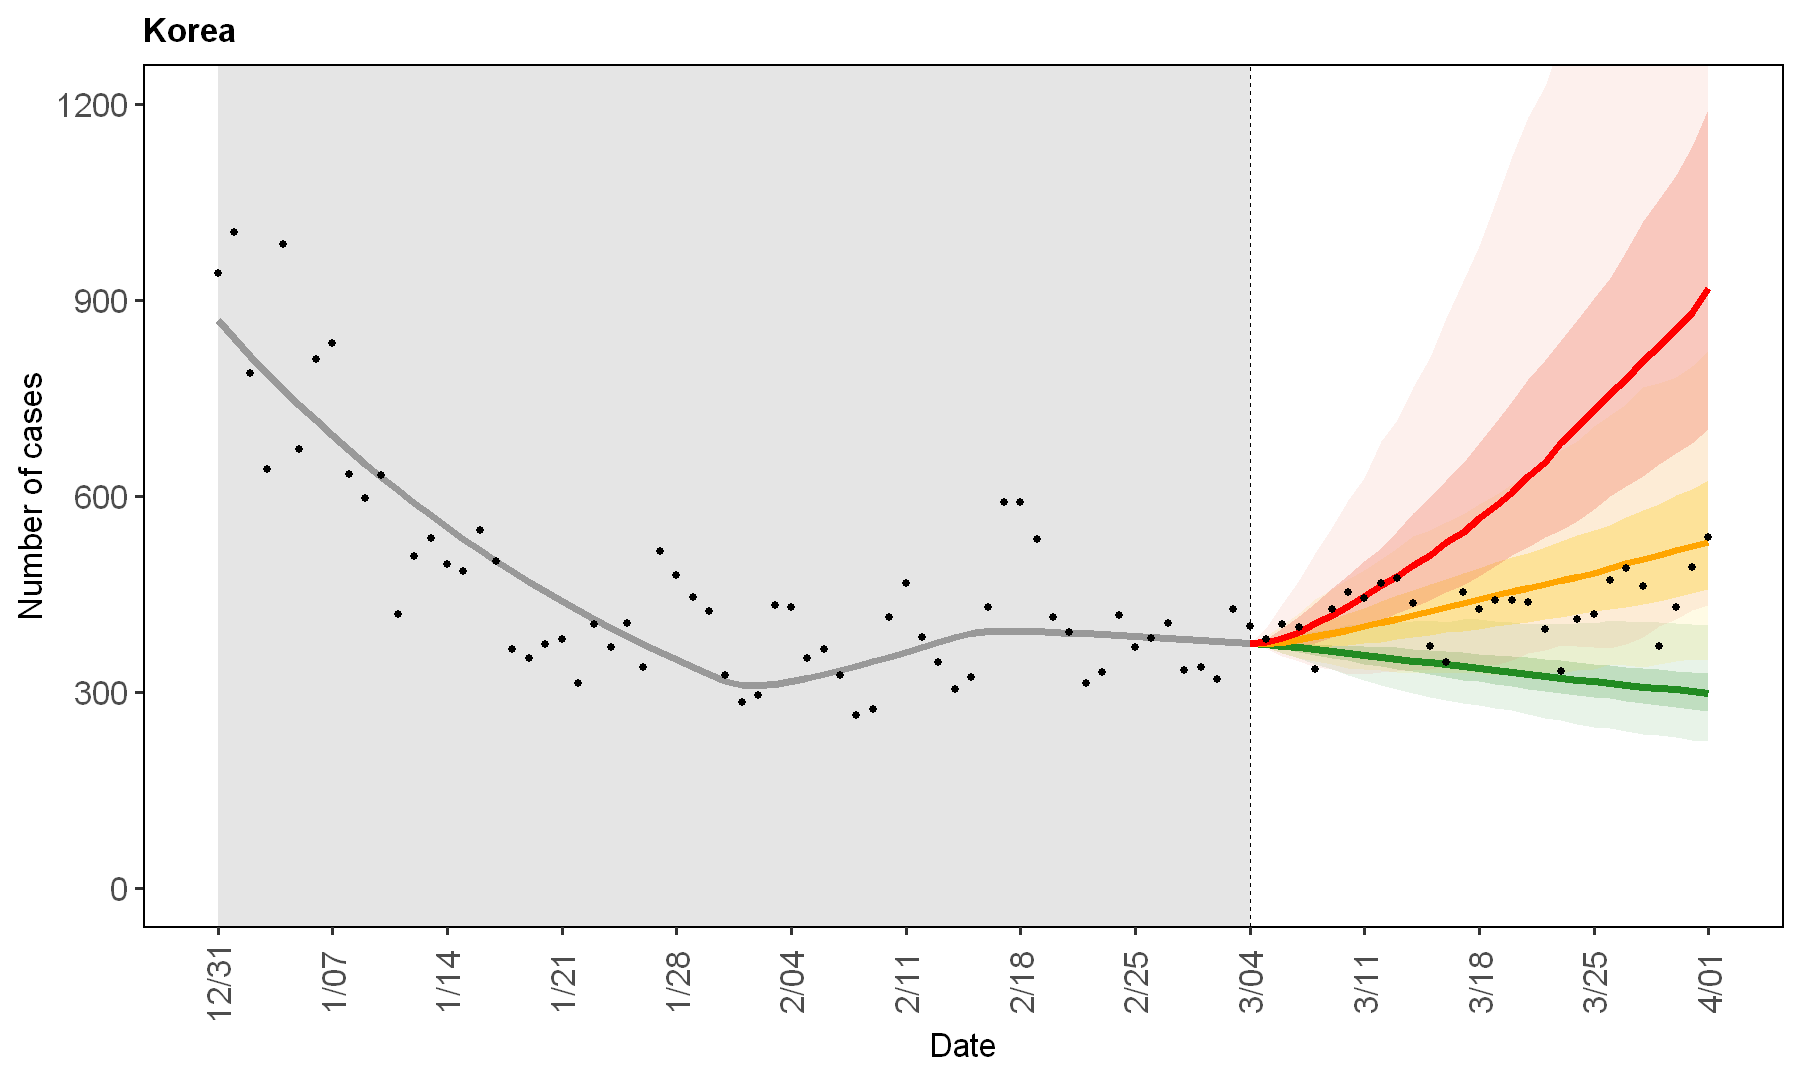

In [12]:
title_names = area_name
source("function_forecasting.R")
  options(repr.plot.width=15,repr.plot.height=9)

fig = ft_forecasting(dfone,df_future,finalday,comp_dfa)
  print(fig)